In [1]:
import nltk, re, pprint, string
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk import trigrams
from nltk.stem.porter import * 
stemmer = PorterStemmer()
import pandas as pd
from operator import itemgetter
import nltk
import os
from collections import Counter
from nltk.corpus import PlaintextCorpusReader
from nltk import trigrams, ngrams
from gensim.parsing.preprocessing import remove_stopwords
import warnings
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file c:\users\mutla\anaconda3\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\users\mutla\anaconda3\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\users\mutla\anaconda3\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality paramet

###### helper function for cleansing corpus

In [2]:
stop_words = open('stop_words_english.txt',encoding = 'utf-8')
stop_words = stop_words.read().splitlines()
def cleanse(string, mode):
    punctuation= ['∼', '°', '″', '×', '…', '!', 'χ', '+', '‘','’',
        '—', '~', '>', '|', '<', '•', '→', '$', '\uf08e', '⋆', '´','•', '¨', 'ˆ', '′', '∑', '‚', '»',
        '«', '²', '€', '≥', '„', '›', '‹', '−', '¼', '£', 'ð', 'Þ', '\uf0b7', '\uf6bc', '∗', '†',
        '◦', '·', '±', '≤', '∏', 'º', '`', '�', '‡', '§', '̸', '⃗', '≪', 'ϕ', 'θ', '®', '≈', 'â', 
        'Ă', 'Ş', '∅', '™', '‐', '\x00', '（', '∕', '）', '𝑚', '\\', '\uffff','&', '–','?','#', '%',
        '=', '∀', '∈', '{', '}', '“', '”', '_', '*', '©',']','``', '’' '"', '[', ':', ';','/', '(', ')',
        "'",'-','.','@',',', '\r', '\n']
    for p in punctuation:
        string = string.replace(p, '')
    if mode ==1:
        pass
    ## remove stopwords
    elif mode ==2:
        words = word_tokenize(string)
        remove_stopwords = list(filter(lambda token: token not in stop_words,words))
        string = ' '.join(remove_stopwords)
    ## perform casefolding
    elif mode == 3: 
        string = string.casefold()
    ## perfform stemming
    elif mode == 4:
        words = word_tokenize(string)
        words = [stemmer.stem(w) for w in words]            
        string = ' '.join(words)
    else: 
        string = string.replace(p, "")
        string = string.casefold()
        words = word_tokenize(string)
        words = [stemmer.stem(w) for w in words]  
        remove_stopwords = list(filter(lambda token: token not in stop_words,words))
        string = ' '.join(remove_stopwords)
    return string


###### getting the documents in nltk from directory

In [3]:
path = 'nltk_data'
import nltk.data
def get_cleanse_corpus(mode):
    path in nltk.data.path
    corpus_root = os.path.expanduser(path)
    corpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
    corpus_txt = " ".join(corpus.words())
    corpus_txt = cleanse(corpus_txt,mode)
    words = corpus_txt.split(' ')
    return words,corpus

##### For documents: calculate the each word's frequency

In [4]:
def calc_documents_words(mode,corpus):
    word_to_doc = []
    documents = []
    for fname in corpus.fileids():
        documents.append(fname)
        text = corpus.raw(fname)
        if mode ==1:
            text = cleanse(text,1)
        elif mode == 2:
            text = cleanse(text,2)
        elif mode == 3: 
            text =  cleanse(text,3)
        else: 
            text =  cleanse(text,4)
        text = text.split(' ')
        words_count = len(text)
        words_occ = dict(Counter(text))
        for key in words_occ.keys():
            words_occ[key] = words_occ[key]/words_count
        word_to_doc.append(words_occ)
    return documents, word_to_doc

###### For Corpus: calculate the each word's frequency

In [5]:
def calc_corpus_words(words):
    corpus_count = len(words)
    words_occ = dict(Counter(words))
    for key in words_occ.keys():
        words_occ[key] = words_occ[key]/corpus_count
    word_to_corpus = words_occ
    return word_to_corpus

Query tokenization

In [6]:
query = 'Eye tracking museum'
query_words = query.split(' ')

calculating weight of each word of the query in each document

In [7]:
def weight_word_doc_4query(query_words,word_to_doc ):
    scores_documents = []
    for q_w in query_words:
        word_scores = []
        for doc in word_to_doc:
            score = 1
            if q_w in doc.keys():
                score *= doc[q_w]+1
            else:
                score = 1
            word_scores.append(score)
        scores_documents.append(word_scores)
    return scores_documents

calculating weight of each word of the query in whole corpus

In [8]:
def weight_word_corpus_4query(query_words,word_to_corpus ):
    scores_corpus = []
    for q_w in query_words:
        if q_w in word_to_corpus.keys():
            scores_corpus.append(1+word_to_corpus[q_w])
        else:
            scores_corpus.append(1)
    return scores_corpus


-calculate the probability of each document for each word in the query, and then,
given the query, the score of each document 

In [9]:
def query_words_documentscore(scores_corpus, scores_documents):
    ranks = []
    for i in range(len(scores_corpus)):
        word_ranks = []
        for j in range(len(scores_documents[i])):
            word_ranks.append(scores_documents[i][j]*scores_corpus[i])
        ranks.append(word_ranks)
    query_doc_rank = []
    for i in range(50):
        query_doc_rank.append(ranks[0][i]*ranks[1][i]*ranks[2][i]) #given the query, the score of each document
    return query_doc_rank

helper function to rank the documents and get the top N documents

In [10]:
def get_ranked_docs(query_doc_rank, N):
    if N>50:
        return False
    res = sorted(range(len(query_doc_rank)), key = lambda sub: query_doc_rank[sub])[-N:]
    return res

### 1. Language Model of the collection

In [11]:
df = pd.DataFrame(columns=['operation', 'tokens', 'unique_tokens'])

In [12]:
tokens,corpus = get_cleanse_corpus(1)
print('Words in Corpus: ' , str(len(corpus.raw())))
df = df.append({'operation': 'No operation', 'tokens': len(tokens), 'unique_tokens': len(Counter(tokens))}, ignore_index = True)
df

Words in Corpus:  2901555


,operation,tokens,unique_tokens
0,No operation,548381,27106


### 2. Linguistic operations
- operations are done above in 'cleanse' function
- the rest of the steps are the same
######  2.1. Remove stop words 

In [13]:
tokens,corpus = get_cleanse_corpus(2)
df = df.append({'operation': 'Stop Words', 'tokens': len(tokens), 'unique_tokens': len(Counter(tokens))}, ignore_index = True)
df

,operation,tokens,unique_tokens
0,No operation,548381,27106
1,Stop Words,258731,26459


######  2.2. Perform CaseFolding

In [14]:
## get docs using nltk from directory
tokens ,corpus = get_cleanse_corpus(3)
df = df.append({'operation': 'Case Folding', 'tokens': len(tokens), 'unique_tokens': len(Counter(tokens))}, ignore_index = True)
df

,operation,tokens,unique_tokens
0,No operation,548381,27106
1,Stop Words,258731,26459
2,Case Folding,548381,22841


######  2.3. Perform Stemming

In [15]:
## get docs using nltk from directory
tokens ,corpus = get_cleanse_corpus(4)
df = df.append({'operation': 'Stemming', 'tokens': len(tokens), 'unique_tokens': len(Counter(tokens))}, ignore_index = True)
df

,operation,tokens,unique_tokens
0,No operation,548381,27106
1,Stop Words,258731,26459
2,Case Folding,548381,22841
3,Stemming,443877,17594


#### Comparing Results

In [16]:
#   operation------tokens-----unique_tokens
# No operation-----548381-----27106
# Stop Words-------258731-----26459
# Case Folding-----548381-----22841
# Stemming---------443877-----17594

#### Take aways: 
- The most effective linguistic operation on the language model in terms of tokens number: removing stop words
- the least effective operation in terms of tokens number: casefolding, the number of tokens stays the same as if no operation was done.
- The most effective linguistic operation on the language model in terms of <b>uniuqe tokens</b>: Stemming, it returns  different words which share the same stem, to the stem. and therefore resulting less unique tokens compared to other operations.
- The least effective linguistic operation on the language model in terms of <b>uniuqe tokens</b>: removing stop words, stopwords are very frequent in documents, removing them is the most effecive operation in terms of the size of the corpus, however it doesn't have a great effect in terms of unique tokens.

In [18]:
print('Top 5 Ranked When Removing Stop Words')
print(stopwords_top)
print('====================================')
print('Top 5 Ranked When Performing Case Fodling')
print(casefolding_top)
print('====================================')
print('Top 5 Ranked When Performing Stemming')
print(stemming_top)

Top 5 Ranked When Removing Stop Words


NameError: name 'stopwords_top' is not defined

We can see a lot of similarities between the three results in the top 5 ranked documents in when performing each operation:
- when removing stopwords Scores in general are higher and have a relatively larger margin between documents
- Document 44 in Top 5 in the Three operations, having a higher score when removing stopwords, while nearly similar in the other two operations, while in casefolding it has a higher rank.
- Document 44 is in top 5 in both when removing stopwords and when performing casefolding
- casefolding and stemming have the same top document (doc 32), the same 4th document (doc 2), and the same documents in rank 2 and 3 with different order.
- We Can Infer from the results that the most effictive operation is Removing Stop words due to the fact that it generated higher scores for documents than the other operations a higher margin between different document's scores which gives more Sure answer, and that it returned different documents than the other two, that means that the other two operations' effect is more similar than removing stopwords 


# Text Classification

###### Read Files Relevant Documents' class: 1, Non-Relevant: 0
- Reading Relevant documents

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix,precision_score,recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
import collections

In [20]:
titles = []
corpus = []
targets = []
target_names = ['Non-Relevant', 'Relevant']
for doc in os.listdir('nltk_data'):
    file = open('nltk_data/' + doc,encoding ='utf-8')
    corpus.append(file.read())
    targets.append(1)
    titles.append(doc)

- Reading non-relevant Documents

In [21]:
for doc in os.listdir('text classification'):
    file = open('text classification/' + doc,encoding ='utf-8')
    corpus.append(file.read())
    targets.append(0)
    titles.append(doc)

cleansing and tokenizing corpus documents

In [22]:
def tokenize(document):
    document = cleanse(document,5)
    document = word_tokenize(document)
    return document

TFIDF matrix for the Input text

In [23]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)
tfidf = vectorizer.fit_transform(corpus)

#### Naive Bayes Classifier

- splitting data to train and test: 90% Train 10% test
- fitting the model

In [24]:
#split into training and test dataset
x_train,x_test,y_train,y_test = train_test_split(tfidf,targets,test_size = 0.1,random_state=0)
#Model Building
naivebayes = MultinomialNB()
#classifier.fit(x_train,y_train)
naivebayes.fit(x_train,y_train)

MultinomialNB()

Accuracy Score: 0.8


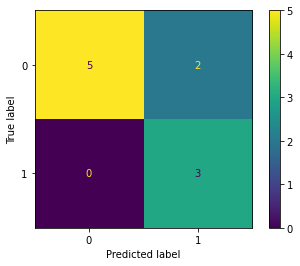

In [25]:
pred = naivebayes.predict(x_test)
plot_confusion_matrix(naivebayes,x_test,y_test)
print('Accuracy Score: '  + str(accuracy_score(y_test,pred)))

###### 10 Fold Cross Validation

In [26]:
k = 10
kf = model_selection.KFold(n_splits=k, shuffle = True,random_state=18)
result = cross_val_score(naivebayes , tfidf, targets, cv = kf)
y_pred = cross_val_predict(naivebayes , tfidf, targets, cv=kf)
print("Avg accuracy: {}".format(result.mean()))


Avg accuracy: 0.9199999999999999


In [27]:
pred_df = pd.DataFrame({'title': titles, 'label': targets, 'pred': y_pred})
pred_df['index'] = pred_df.index
pred_df

,title,label,pred,index
0,A Novel Image Based Positioning Technique Usin...,1,1,0
1,A review of eye-tracking research in tourism.txt,1,1,1
2,Aesthetic Dissonance The Impact of Viewing Fin...,1,1,2
3,Allophonic tunes of contrast_ Lab and spontane...,1,1,3
4,An Eye-Tracking Dataset for Visual Attention M...,1,1,4
...,...,...,...,...
95,PERSONALIZATION ENVISAGED IN MUSEUM APPLICATIO...,0,0,95
96,RSSI-Based_WLAN_Indoor_Positioning_Used_Within...,0,0,96
97,Suitability of Eye Tracking in Assessing the V...,0,1,97
98,Teaching cultural heritage using mobile augmen...,0,0,98


In [28]:
pred_df[pred_df['label'] != pred_df['pred']]

,title,label,pred,index
8,CURATING DIGITAL IMAGES_ ETHNOGRAPHIC PERSPECT...,1,0,8
13,Exploring the Affective Museum Visiting Experi...,1,0,13
64,A Museum Visitors Classification Based On Beha...,0,1,64
67,A TECHNIQUE FOR STUDYING THE BEHAVIOROF MUSEUM...,0,1,67
75,"Augmented Reality for Art, Design and Cultural...",0,1,75
85,Development of a Mobile Museum Guide Robot Tha...,0,1,85
86,Exploring the potential of a mobile eye tracke...,0,1,86
97,Suitability of Eye Tracking in Assessing the V...,0,1,97


finding most occorent words in relevant docs

In [29]:
tokenized = [tokenize(doc) for doc in corpus[:50]]
words = []
for i in tokenized:
    words.extend(i)

In [30]:
counter  = dict(Counter(words))
ws = []
most_rel = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])

for i in most_rel.keys():
    most_rel[i] = most_rel[i]/sum(list(counter.values()))+1


In [31]:
most_rel

{'exhibit': 1.0102031659427833,
 'eye': 1.0098980580781793,
 'museum': 1.0091801572202879,
 'thi': 1.0091622096988406,
 'visitor': 1.008394953156969,
 'wa': 1.0065912272515165,
 'studi': 1.0061874080189526,
 'movement': 1.0056893642987903,
 'gaze': 1.0051733730571808,
 'experi': 1.0050612010481352}

finding most occorent words in non - relevant docs

In [32]:
tokenized = [tokenize(doc) for doc in corpus[50:]]
words = []
for i in tokenized:
    words.extend(i)
counter  = dict(Counter(words))
ws = []
most_nonrel = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])

for i in most_nonrel.keys():
    most_nonrel[i] = most_nonrel[i]/sum(list(counter.values()))+1
most_nonrel

{'museum': 1.0125864059034848,
 'visitor': 1.008974541870388,
 'thi': 1.008475235711414,
 'user': 1.0079888985435823,
 'mobil': 1.005518305730997,
 'inform': 1.0053691623328622,
 'wa': 1.0050189995720233,
 'experi': 1.0048698561738882,
 'visit': 1.0047336817668953,
 'interact': 1.0043575810237722}

#### Take aways:
- We can see already that in the most effective words in relevant documents, can be also the one of the most effective words in the non-relevant documents.
- museum, visitor,thi,wa all are in the top 10 most occuring words of both relevant and non-relevant documents <b> Which might be the reason for the False results. </b>

In [33]:
false_pred = pred_df[pred_df['label'] != pred_df['pred']]['index'].tolist()[:5]

In [34]:
for i in false_pred:
    sum_rel = 1
    sum_nonrel = 1
    tok = tokenize(corpus[i])
    for word in tok:
        if word in most_rel.keys():
            sum_rel *= most_rel[word]
        if word in most_nonrel.keys():
            sum_nonrel *= most_nonrel[word]
    print(str(i) + ': '+ titles[i])
    print('True Category: ' + str(targets[i]))
    print('Relevant Probability: ' +str(sum_rel))
    print('Non-Relevant Probability: ' +str(sum_nonrel))
    print('===========================')


8: CURATING DIGITAL IMAGES_ ETHNOGRAPHIC PERSPECTIVES ON THE AFFORDANCES OF DIGITAL IMAGES IN MUSEUM AND HERITAGE CONTEXTS.txt
True Category: 1
Relevant Probability: 8.2792649480964
Non-Relevant Probability: 9.238112207594506
13: Exploring the Affective Museum Visiting Experience_ Adaptive Augmented Reality (A2R) and Cultural Heritage.txt
True Category: 1
Relevant Probability: 17.874566321134157
Non-Relevant Probability: 40.710632854076145
64: A Museum Visitors Classification Based On Behavioral and Demographic Features.txt
True Category: 0
Relevant Probability: 3.8704279229470235
Non-Relevant Probability: 5.6837903325394965
67: A TECHNIQUE FOR STUDYING THE BEHAVIOROF MUSEUM VISITORS.txt
True Category: 0
Relevant Probability: 2.2760739332829063
Non-Relevant Probability: 1.9259951644277171
75: Augmented Reality for Art, Design and Cultural Heritage - System Design and Evaluation.txt
True Category: 0
Relevant Probability: 2.51141861165159
Non-Relevant Probability: 2.844876569848517


##### Conclusions


##  Logistic Regression Classifier

Accuracy Score: 0.9


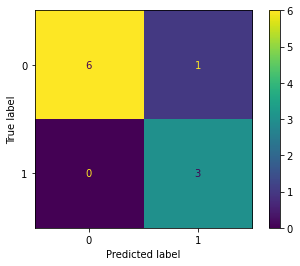

In [35]:
# Construct a confusion matrix
test_size = 0.1
seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, targets, test_size=test_size,
random_state=seed)
logReg = LogisticRegression(solver='liblinear')
logReg.fit(X_train, Y_train)
predicted = logReg.predict(X_test)
print('Accuracy Score: '  + str(accuracy_score(Y_test,predicted)))
plot_confusion_matrix(logReg,X_test, Y_test)

###### 10 Fold Cross Validation

In [36]:
# 10 folds selected
kfold = KFold(n_splits=10, random_state=0, shuffle=True)
logReg = LogisticRegression(solver='liblinear')
pred = cross_val_score(logReg, tfidf, targets, cv=kfold)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Average 10 Folds CV Accuracy: %.3f%% " % (pred.mean()*100.0))

Average 10 Folds CV Accuracy: 94.000% 


In [37]:
y_pred = cross_val_predict(logReg , tfidf, targets, cv=kf)
pred_df = pd.DataFrame({'title': titles, 'label': targets, 'pred': y_pred})
pred_df['index'] = pred_df.index
pred_df[pred_df['label'] != pred_df['pred']]
false_pred = pred_df[pred_df['label'] != pred_df['pred']]['index'].tolist()[:5]
for i in false_pred:
    sum_rel = 1
    sum_nonrel = 1
    tok = tokenize(corpus[i])
    for word in tok:
        if word in most_rel.keys():
            sum_rel *= most_rel[word]
        if word in most_nonrel.keys():
            sum_nonrel *= most_nonrel[word]
    print(str(i) + ': '+ titles[i])
    print('True Category: ' + str(targets[i]))
    print('Relevant Probability: ' +str(sum_rel))
    print('Non-Relevant Probability: ' +str(sum_nonrel))
    print('===========================')


8: CURATING DIGITAL IMAGES_ ETHNOGRAPHIC PERSPECTIVES ON THE AFFORDANCES OF DIGITAL IMAGES IN MUSEUM AND HERITAGE CONTEXTS.txt
True Category: 1
Relevant Probability: 8.2792649480964
Non-Relevant Probability: 9.238112207594506
13: Exploring the Affective Museum Visiting Experience_ Adaptive Augmented Reality (A2R) and Cultural Heritage.txt
True Category: 1
Relevant Probability: 17.874566321134157
Non-Relevant Probability: 40.710632854076145
22: Full Access to Cultural Spaces (FACS)_ Mapping and evaluating museum access services using mobile eye-tracking technology.txt
True Category: 1
Relevant Probability: 8.800648841575178
Non-Relevant Probability: 12.786846486301355
47: using eye-tracking to unveil differences between kids and teens in coding activities.txt
True Category: 1
Relevant Probability: 3.533311194648189
Non-Relevant Probability: 2.0652459354786665
85: Development of a Mobile Museum Guide Robot That Can Configure Spatial Formation with Visitors.txt
True Category: 0
Relevant P

In [38]:
svd = TruncatedSVD()
x_svd = svd.fit_transform(tfidf)
x_svd = pd.DataFrame(x_svd)
x_svd.rename(columns = {0:'x', 1:'y'}, inplace = True)
x_svd['label'] = targets
x_svd

,x,y,label
0,0.650239,0.072338,1
1,0.432297,0.275539,1
2,0.359605,-0.028141,1
3,0.169050,0.052026,1
4,0.322916,0.083685,1
...,...,...,...
95,0.408868,-0.297233,0
96,0.325514,-0.078180,0
97,0.441388,0.202444,0
98,0.356223,-0.126536,0


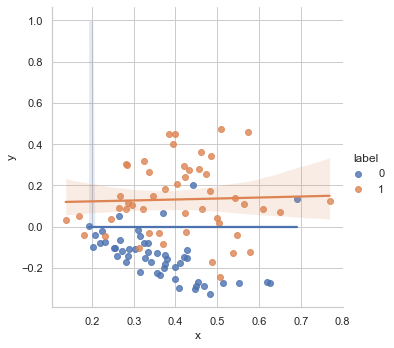

In [202]:
sns.lmplot(x='x', y='y', data=x_svd,hue = 'label', logistic=True,fit_reg= True)

####  K Nearest Neighbor Classifier

### Conclusions


Accuracy Score: 0.9


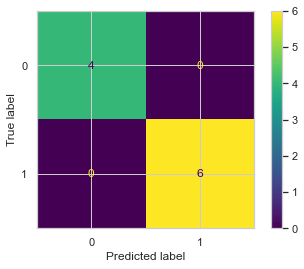

In [206]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(tfidf,targets, test_size=0.1, random_state=1, stratify=targets)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print('Accuracy Score: '  + str(accuracy_score(Y_test,predicted)))
plot_confusion_matrix(knn,X_test,predictions)

###### 10 Fold Cross Validation

In [207]:
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)
#train model with cv of 10
k = 10
kf = model_selection.KFold(n_splits=k, shuffle = True,random_state=0)
y_pred = cross_val_predict(knn_cv , tfidf, targets, cv=kf)
cv_scores = cross_val_score(knn_cv, tfidf, targets, cv=10)
#print each cv score (accuracy) and average them

print('cv Accuracy mean:{}'.format(np.sum(cv_scores)/10))

cv Accuracy mean:0.89


In [217]:
pred_df = pd.DataFrame({'title': titles, 'label': targets, 'pred': y_pred})
pred_df['index'] = pred_df.index
pred_df[pred_df['label'] != pred_df['pred']]
false_pred = pred_df[pred_df['label'] != pred_df['pred']]['index'].tolist()
false_pred

[8, 13, 30, 53, 61, 62, 64, 67, 68, 86, 97]

- Now let's take the first wrong prediction, document 8: 
- let's calculate it's euclidean distance of the other documents and see it's nearest neighbors.

In [267]:
doc = tfidf[8]
cosine_sim = []
for i in tfidf:
    cosine_sim.append(cosine_similarity(doc, i))
cosine_sim = [cosine_sim[i][0][0] for i in range(len(cosine_sim))]
print(cosine_sim)

[0.2363937558840326, 0.15158752149727298, 0.16347377357787313, 0.04141545323613405, 0.10262512734237536, 0.11870205296664404, 0.14730374666190674, 0.13031892290057415, 0.9999999999999994, 0.2047050811534517, 0.18105386681968508, 0.1327707788450599, 0.08502317515325174, 0.19887169478617445, 0.26042343460881073, 0.16714577546126191, 0.07225393151588634, 0.0984677354801553, 0.12205029172479287, 0.12279293664011756, 0.10711837294438645, 0.1283134493002066, 0.18185954489228007, 0.1405524751576889, 0.11824101185788026, 0.13981335753370866, 0.15672529917948402, 0.18850243130557245, 0.0733026626432549, 0.10817736734691942, 0.030730551740238792, 0.1394868545815925, 0.18310186359154595, 0.08488191906610351, 0.16197083489617342, 0.09434774759724497, 0.1444856926407944, 0.12362253219899663, 0.07325095752924607, 0.06862233907048446, 0.22496324765865364, 0.14087586554207407, 0.24301239659891033, 0.12001756838278023, 0.21986719134183813, 0.14037221340231298, 0.1940086213170651, 0.0908992388807265, 0.

In [268]:
minimum_cosine_sim = [0.030730551740238792, 0.04141545323613405, 0.0517950516411581]
for i in minimum_cosine_sim:
    print(cosine_sim.index(i))


30
3
85


#### Support Vector Machine(SVM) Classifier

Splitting train 90% - test 10%, fitting the model and predicting

#### Conclusions: 



In [271]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, targets, test_size=0.1,random_state=109)
#create a classifier
svm_cl = svm.SVC(kernel="linear")
#train the model
svm_cl.fit(X_train,y_train)
#predict the response
pred = svm_cl.predict(X_test)

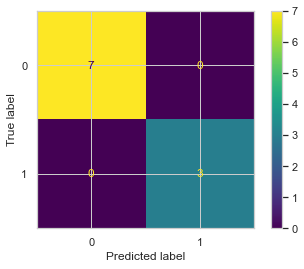

In [272]:
plot_confusion_matrix(svm_cl,X_test,pred)

In [273]:
#accuracy
print("acuracy:", accuracy_score(y_test,y_pred=pred))

acuracy: 0.9


Confusion Matrix Describing The Resutls

###### 10 Fold Cross Validation

In [283]:
svm_clf = svm.SVC(kernel = "linear")
k = 10
kf = model_selection.KFold(n_splits=k, shuffle = True,random_state=0)
y_pred = cross_val_predict(svm_clf , tfidf, targets, cv=kf)
cv_scores = cross_val_score(svm_clf, tfidf, targets, cv=10)
#print each cv score (accuracy) and average them
print('folds scores:')
print(cv_scores)
print('cv_scores average accuracy:{}'.format(sum(cv_scores)/10))

folds scores:
[1.  0.9 0.9 1.  1.  1.  1.  0.9 1.  0.9]
cv_scores average accuracy:0.96


In [284]:
pred_df = pd.DataFrame({'title': titles, 'label': targets, 'pred': y_pred})
pred_df['index'] = pred_df.index
pred_df[pred_df['label'] != pred_df['pred']]

,title,label,pred,index
8,CURATING DIGITAL IMAGES_ ETHNOGRAPHIC PERSPECT...,1,0,8
13,Exploring the Affective Museum Visiting Experi...,1,0,13
86,Exploring the potential of a mobile eye tracke...,0,1,86
97,Suitability of Eye Tracking in Assessing the V...,0,1,97


#### Conclusions: 
- One of the things that might cause wrong classifications in SVM is when we are using data that's dimensionality is far greater than the training datas size.


In [285]:
classification_df = pd.DataFrame({'model': ['Naive Bayes', 'Logistic Regression', 'KNN', 'SVM'],
                                 'Accuracy': [0.8,0.9,0.9,0.9],
                                 '10F CV AVG Accuracy': [0.92,0.94,0.89,0.96]})
classification_df

,model,Accuracy,10F CV AVG Accuracy
0,Naive Bayes,0.8,0.92
1,Logistic Regression,0.9,0.94
2,KNN,0.9,0.89
3,SVM,0.9,0.96


#### Conclusions: 
###### Naive Bayes
- We have calculated above the probability for each document to belong to each of the categories based on the probability of each word of the top 10 words in Relevant, and top 10 words in non-relevant documents in each of the categories.
- We can see clearly that if the document has more of the opposite categorys top words there is a higher probability that the classifier might classify it wrong.
###### Logistic Regression
- By looking at Probabilities we see that this way the false category might get higher probability than the true one. However this does not help us to understand the results including why those were classified falsly. 
- Points representing documents might fall in the area of the other category, as the plot shows, we can see that non-Relevant documents fall into Relevant side of the seperator, and the some relevant documents fall on the non-relevant side.
###### KNN
- Wrong classifications in KNN is usually due to the fact that it ignores centroids and classifies the document similar to the k most similar documents, in our case we used 3 nearest neighbors, the more the neighbors we use the more accurate the model becomes, but also it then is more comlex and slower. The cause of the wrong classification might be that we didn't use enough neighbors, and the nearest neighbors of these texts are from the different category. 
- The 3rd most cosine similar document is from a different class(category), so it's not a surprise if according to KNN's distance calculation the KNNs are from the other category.
###### SVM
- classifying using SVM is better when we have two classes, as the litureture indicates, when we have multi-class classification SVMs becomes less effecient.

# Clustering

Looking at the various classifiers we can infer that most of the time the probability of a document to be catogerized to a certain category depending on the most important words in each one, and calculating their weight (it's occerneces*its weight) / total(weight*occorences) of other words in the document, we get that this has an impact and we can say that this is the main reason for the false classification

In [287]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

importing documents

In [288]:
os.listdir('Clusters')

['Augmented reality cultural heritage',
 'Mobile Tourists Guides',
 'Personalization in cultural heritage',
 'Technolgy in Museums']

In [457]:
titles  = []
X  = []
y = []
document_list = []
cluster_map = {0: 'Eye tracking museum',
              1:  'Augmented reality cultural heritage',
              2:  'Mobile Tourists Guides',
              3:  'Personalization in cultural heritage' }
for doc in os.listdir('nltk_data'):
    file = open('nltk_data/' + doc,encoding ='utf-8')
    X.append(file.read())
    y.append(0)
    titles.append(doc)

    
#reading documents from other directories
for doc in os.listdir('Clusters/Augmented reality cultural heritage/'):
    file = open('Clusters/Augmented reality cultural heritage/' + doc,encoding ='utf-8')
    X.append(file.read())
    y.append(1)
    titles.append(doc)

for doc in os.listdir('Clusters/Mobile Tourists Guides/'):
    file = open('Clusters/Mobile Tourists Guides/' + doc,encoding ='utf-8')
    X.append(file.read())
    y.append(2)
    titles.append(doc)
       
for doc in os.listdir('Clusters/Personalization in cultural heritage/'):
    file = open('Clusters/Personalization in cultural heritage/' + doc,encoding ='utf-8')
    X.append(file.read())
    y.append(3)
    titles.append(doc)
document_list = X

TFiDF vectorizing for all documents

In [458]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(X)
X

<200x102208 sparse matrix of type '<class 'numpy.float64'>'
	with 265940 stored elements in Compressed Sparse Row format>

Fitting the model with 4 clusters

In [459]:
#  = KMeans(n_clusters=4, random_state=42)
kmeans = KMeans(init="k-means++", n_clusters=4,max_iter=25)

# fit the model
labels = kmeans.fit(X)
clusters = kmeans.labels_
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3, 0, 3,
       3, 3])

#### Confusion Maxtrix Showing Results


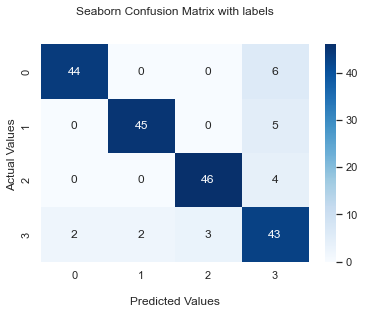

In [460]:
cm =confusion_matrix(y,clusters)
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()

<b> Wrong Cluster Assignments:</b> 
- 6 documents of class 0 (Eye Tracking Museum) were grouped with the (Personalization in cultural heritage) class.
- 5 document of class 1 (Augmented reality cultural heritage) was grouped with (Personalization in cultural heritage) class.
- 4 documents of class (Mobile Tourists Guides) were grouped with  (Personalization in cultural heritage) class.
- 7 documents of class (Personalization in cultural heritage) were grouped with other clusters. 

### Evaluating Clustering using Adjusted Rand Index

In [461]:
from sklearn.metrics.cluster import adjusted_rand_score
print('Adjusted Rand Index: ' + str(adjusted_rand_score(y, clusters)))

Adjusted Rand Index: 0.7267123078644598


Rand idex computes the randomness in the classification. here we're talking about grouping, so we are measuring the randomness of the affiliation of clusters made by kmeans, we got a moderate score. 

Dimensional Reduction and Visualization
- using PCA

In [462]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

represinting each document as 2 diminsional

In [463]:
x0

array([ 0.32924258,  0.32750529,  0.21814076,  0.08906725,  0.17825061,
        0.23733876,  0.30216408,  0.25734452,  0.13497119,  0.23767446,
        0.34625932,  0.1403021 ,  0.29890037,  0.12826784,  0.45180096,
        0.30982092,  0.17290097,  0.15547163,  0.45866408,  0.38766295,
        0.40181958,  0.28533   ,  0.12145614,  0.31278995,  0.42489998,
        0.18493132,  0.54420579,  0.23042235,  0.15230888,  0.06980411,
        0.05693256,  0.35402565,  0.28934749,  0.10923984,  0.33921358,
        0.26682957,  0.54331301,  0.44718083,  0.15806688,  0.16830076,
        0.43433509,  0.36906492,  0.31920523,  0.22017993,  0.25323512,
        0.19948314,  0.37686367,  0.09858241,  0.25568709,  0.31741804,
       -0.01817864, -0.05679764,  0.0311626 ,  0.09313564,  0.05861179,
       -0.11255065, -0.00583818, -0.06969473, -0.03033107, -0.03587189,
        0.06244958,  0.11954271,  0.01110868, -0.028878  , -0.00763037,
       -0.10341298, -0.05052168, -0.08617419, -0.07988234, -0.05

In [464]:
x1

array([-0.13022555, -0.14956646, -0.05735206, -0.05503603,  0.02977454,
        0.02240595,  0.04497833, -0.07122925,  0.03045699, -0.09380379,
       -0.09057028, -0.0267793 , -0.12116138,  0.19089633, -0.15628428,
       -0.09414629, -0.07598434, -0.04710993, -0.1931126 , -0.07229041,
       -0.0094699 , -0.10163586, -0.06743352, -0.07863128, -0.10364149,
       -0.04010547, -0.24257188, -0.05290771, -0.04411407, -0.02286632,
       -0.04896879, -0.11117468, -0.09041092, -0.0256173 , -0.12591004,
       -0.06548065, -0.23113399, -0.12643577, -0.10655263, -0.02078909,
       -0.10893978, -0.1238524 , -0.07664536, -0.08458555, -0.05669436,
       -0.06063232, -0.15460213, -0.03050247,  0.05775758, -0.15586806,
        0.20227153,  0.08349287,  0.19603292,  0.20119266,  0.22356316,
        0.30770022,  0.21848796,  0.13110778,  0.27760931,  0.27208949,
        0.24427094,  0.22226112,  0.08914159,  0.32065764,  0.21710971,
        0.29648604,  0.50803564,  0.18922202,  0.25054961,  0.22

In [465]:
df  = pd.DataFrame({'title': titles, 'label': y, 'cluster': clusters,  'x0': x0 ,'x1': x1})
df['cluster'] = df['cluster'].map(cluster_map)
df['label'] = df['label'].map(cluster_map)

Visualization of Clustering

In [521]:
pca_vecs = pca.fit_transform(kmeans.cluster_centers_)
x0_cent = pca_vecs[:, 0]
x1_cent = pca_vecs[:, 1]

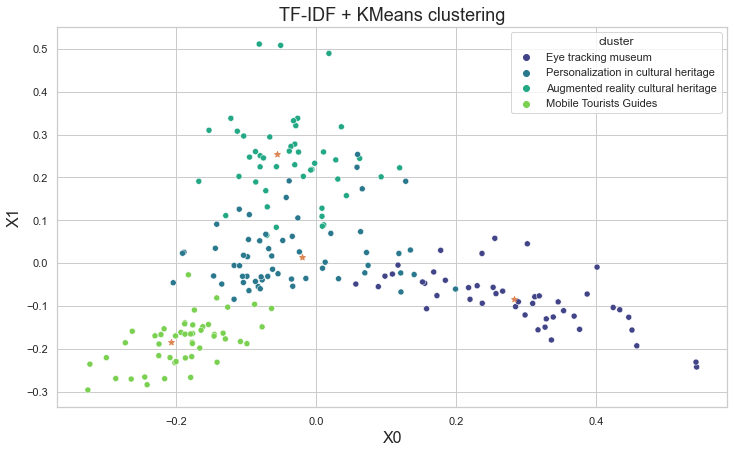

In [524]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.scatter(x0_cent, x1_cent, marker = '*')
plt.show()

##### Results

True Labels of Cluster 0: documentID : 0-49 <br>
True Labels of Cluster 1: documentID : 50-99 <br>
True Labels of Cluster 2: documentID : 100-149 <br>
True Labels of Cluster 3: documentID : 150-199 

In [535]:
print('Cluster 0:')
print('predicted Documents:', str(len(df[df['cluster'] == 'Eye tracking museum'])))
print(df[df['cluster'] == 'Eye tracking museum'].index)
print('=====================================================')
print('Cluster 1:')
print('predicted Documents:', str(len(df[df['cluster'] == 'Augmented reality cultural heritage'])))
print(df[df['cluster'] == 'Augmented reality cultural heritage'].index)
print('=====================================================')
print('Cluster 2:')
print('predicted Documents:', str(len(df[df['cluster'] == 'Mobile Tourists Guides'])))
print(df[df['cluster'] == 'Mobile Tourists Guides'].index)
print('=====================================================')
print('Cluster 3:')
print('predicted Documents:', str(len(df[df['cluster'] == 'Personalization in cultural heritage'])))
print(df[df['cluster'] == 'Personalization in cultural heritage'].index)

Cluster 0:
predicted Documents: 46
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  12,  14,  15,
             16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,  30,
             31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
             44,  46,  47,  48,  49, 170, 196],
           dtype='int64')
Cluster 1:
predicted Documents: 47
Int64Index([ 50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,
             64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
             78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  89,  90,  91,
             93,  94,  95,  97,  98,  99, 176, 193],
           dtype='int64')
Cluster 2:
predicted Documents: 49
Int64Index([100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113,
            114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128,
            129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142,
            143, 144, 145, 146, 147, 148, 149, 15

wrongly predicted documents

In [467]:
df[df['label']!=df['cluster']]

,title,label,cluster,x0,x1
8,CURATING DIGITAL IMAGES_ ETHNOGRAPHIC PERSPECT...,Eye tracking museum,Personalization in cultural heritage,0.134971,0.030457
11,Does Viewing Art in the Museum Reduce Anxiety ...,Eye tracking museum,Personalization in cultural heritage,0.140302,-0.026779
13,Exploring the Affective Museum Visiting Experi...,Eye tracking museum,Personalization in cultural heritage,0.128268,0.190896
22,Full Access to Cultural Spaces (FACS)_ Mapping...,Eye tracking museum,Personalization in cultural heritage,0.121456,-0.067434
29,Linguistics in a Science Museum_ Integrating R...,Eye tracking museum,Personalization in cultural heritage,0.069804,-0.022866
45,using eye movement data and visit contexts to ...,Eye tracking museum,Personalization in cultural heritage,0.199483,-0.060632
54,Adaptive augmented reality for cultural herita...,Augmented reality cultural heritage,Personalization in cultural heritage,0.058612,0.223563
77,iMARECULTURE.txt,Augmented reality cultural heritage,Personalization in cultural heritage,-0.042623,0.153064
88,Tailoring the Adaptive Augmented Reality (A2R)...,Augmented reality cultural heritage,Personalization in cultural heritage,0.059443,0.253575
92,The Augmented Van Gogh’s Augmented Reality.txt,Augmented reality cultural heritage,Personalization in cultural heritage,0.066114,0.173259


We can see that Eye tracking museum has a the most documents which got affiliated to the wrong cluster, particularly to Personalization in cultural heritage cluster: 
- 7 Eye Tracking Museum documents were predicted as Personalization in cultural heritage.
- 5 Augmented reality cultural heritage Documents were predicted as Personalization in cultural heritage. 
- 4 Mobile Tourists Guides	Documents were predicted as Personalization in cultural heritage. 
- 7  Personalization in cultural heritage were predicted as other clusters
- Looking at the plot above, we can see that overlapping points between the two clusters, it can be that a document is closer to the another cluster
- Most of the mispredicted  documents(i.e documents were clustered to the wrong clusters) are misclustered to the Personalization in cultural heritage, in addition 7 documents of this cluster were misclassified to other clusters wrongly with no particular cluster that dominated the wrong clusterings(no cluster of the other 3 had a lot of documents from Personalization in cultural heritage cluster compared to the other clusters).
- By the visualization above we can see that this cluster have overlapping points with all other clusters, and it comes in the middle of the space model, which explaines why most of the misclustered documents were affiliated with it. <br> Documents of other clusters might have euclidean distance closer to the centroid of this cluster although they're part of other clusters, which can explain the cause of this affiliation. 
- Documents of clusters might be less relevant to the predefined cluster, or the document might even be suitable to be affiliated to more than one cluster with similarity to a single one higher than the other, this might cause the occurance of the wrong affiliations above 